In [1]:
##导入需要的包
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as snn
import scipy.io
data = scipy.io.loadmat('P2.mat')
filename = 'columns.txt'  # 待读取的文件名

with open(filename, 'r') as f:
    lines = f.readlines()  # 读取所有行

columns = [line.strip() for line in lines]  # 去掉每行的换行符，并将每行作为一个元素添加到列表中

p2_data = data['p2']
df = pd.DataFrame(data=p2_data,columns=columns)  ## 为了后续提取特征，这里将问题一中预处理后的数据以及变量名称整理成一个df
# print(df)

In [11]:
# 1- 方差筛选
# df.head(5) ##为了验证数据是否正确
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

## 自变量值与因变量
x = df.drop('产品辛烷值',axis=1) 
y_s = df['产品硫含量']
X = x.drop('产品硫含量',axis = 1)
y = df['产品辛烷值']

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 对数据集进行归一化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 使用方差筛选选择特征
sel = VarianceThreshold(threshold=1)
X_train = sel.fit_transform(X_train)
X_test = sel.transform(X_test)

# 查看被选择的特征
selected_features = X.columns[sel.get_support()]
print(type(selected_features))
print("被选择的特征：",list(selected_features))
print(len(list(selected_features)))
# print(y_s)

#### 该方法效果不是很好 


<class 'pandas.core.indexes.base.Index'>
被选择的特征： ['原料烯烃', '再生吸附-焦炭', '氢油比', '反应器上部温度', 'D105温度', '稳定塔顶压力', '稳定塔液位', '塔顶回流罐D201液位', '精制汽油出装置温度', '精制汽油出装置流量', '蒸汽进装置压力', '干气出装置流量', '氮气进装置压力', '非净化风进装置流量', '辐射室出口压力', '加热炉主火嘴瓦斯入口压力', '加热炉主火嘴阀前压力', '反应系统压力', '再生烟气氧含量', '火炬气排放累计流量', '原料进装置流量累计1', 'E-101A壳程出口管温度', 'D-202液位', 'D123冷凝水罐液位', 'D-109松动风流量', 'D-107底排放滑阀压差', 'D-105下锥体松动风流量', '再生器顶部/再生器接收器差压', '再生器下部温度', '再生器接收器/LH差压', '循环氢压缩机出口去混氢点压力', 'E-206壳程出口管温度', '冷氮气过滤器ME-114差压', '空气预热器烟气出口压力', '还原器LH差压', '闭锁料斗氧含量', 'R-102床层吸附剂料位密度', 'R-102底排放滑阀后氮气线压力', 'R-101床层中部温度', 'R-101床层下部温度', 'ME-109过滤器差压', 'K-103出口去K-101出口管流量', 'K-103A进气压力', 'K-103A进气温度', 'K-102B进气压力', 'K-102B进气温度', 'K-102A进气压力', 'K-101B进气压力', 'F-101辐射室出口压力', 'F-101出口支管#4温度', 'EH-103加热元件温度', 'EH-103加热元件温度', 'E-106管程出口管温度', 'S_ZORB AT-0008', 'S_ZORB AT-0013', '过滤器ME-101压差', '再生器藏量', '汽油产品去气分流量']
58
0       3.2
1       3.2
2       3.2
3       3.2
4       3.2
       ... 
320     3.2
321     3.2
322     3.2
323     3.6
324    11.8
Name: 产品

In [12]:
## 2. 皮尔逊相关系数进行特征筛选
corr_matrix = df.corr()
corr_with_price = corr_matrix['产品辛烷值'].abs().sort_values(ascending=False)
# 打印相关系数最高的前60个变量
print(corr_with_price[:70])

产品辛烷值           1.000000
原料辛烷值           0.973372
催化汽油进装置总流量      0.524957
3#催化汽油进装置流量     0.504987
原料进装置温度         0.502303
                  ...   
R-101下部床层压降     0.244256
nan             0.243720
反吹氢气压力          0.243066
汽油产品去气分累积流量     0.242833
加热炉主火嘴瓦斯入口压力    0.242021
Name: 产品辛烷值, Length: 70, dtype: float64


In [13]:
lst1 =[]
with open('产品辛烷值相关系数.txt','r') as f:
    for line in f:
        lst1.append(line.strip('\n').split('   ')[0])
print(len(lst1))  ##利用皮尔逊相关系数筛选出59个变量，用于Lasso正则化进一步提取特征变量

59


In [14]:
## 采用L1正则化筛选特征,L1正则化筛选特征要求自变量与因变量之间要存在一定的线性关系才可以有效的筛选特征
X = df[lst1]
# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# 标准化数据集
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import Lasso

# 创建模型
lasso = Lasso(alpha=0.001)

from sklearn.metrics import mean_squared_error

# 训练模型
lasso.fit(X_train, y_train)

# 在测试集上评估模型性能
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: {:.2f}".format(mse))

# 输出选择的特征
selected_features = [i for i, coef in enumerate(lasso.coef_) if coef != 0]
selected_feature_names = [columns[i] for i in selected_features]
print("Selected feature names: {}".format(selected_feature_names))
print(len(selected_feature_names))

selected_feature1 = selected_feature_names

MSE: 0.04
Selected feature names: ['原料硫含量', '原料辛烷值', '原料饱和烃', '原料密度', '待生吸附-焦碳', '待生吸附S', '还原器压力', '反应器上部温度', '反应器底部温度', '反应器顶部压力', '反应器顶底压差', '反应过滤器压差', 'D105压力', 'D105流化氢气流量', '反吹氢气压力', '稳定塔下部温度', '稳定塔液位', '塔顶回流罐D201液位', '精制汽油出装置温度', '精制汽油出装置流量', '精制汽油出装置硫含量', '蒸汽进装置压力', '蒸汽进装置流量', '轻烃出装置流量', '污油出装置', '燃料气进装置压力', '燃料气进装置流量', '氮气进装置流量', '氮气进装置压力', '循环水进装置流量', '循环水出装置流量', '0.3MPa凝结水出装置流量', '净化风进装置流量', '净化风进装置压力', 'D107提升氮气流量', '3#催化汽油进装置流量', '原料泵出口流量', '原料进装置流量']
38


In [15]:
## 第三步筛选：在上面经过L1正则化筛选后的特征里面进行相关系数分析，剔除掉自变量直接相关系数较高的变量
X2 = df[selected_feature1]
corr2 = X2.corr()
corr2_arr = corr2.to_numpy()
del_index = []
for i in range(corr2_arr.shape[0]):
    for j in range(i+1,corr2_arr.shape[1]):
        if abs(corr2_arr[i][j])>=0.6:
            del_index.append(selected_feature1[i])
del_feature = list(set(del_index))
print(list(set(del_index)))
# print(corr2.to_numpy())

['反应器顶底压差', '稳定塔下部温度', '还原器压力', '反应器顶部压力', '精制汽油出装置硫含量', '原料饱和烃', '精制汽油出装置温度', '反吹氢气压力', '反应过滤器压差', '塔顶回流罐D201液位', '原料进装置流量', '反应器上部温度', 'D105压力']


d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 39030 (\N{CJK UNIFIED IDEOGRAPH-9876}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 24213 (\N{CJK UNIFIED IDEOGRAPH-5E95}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21387 (\N{CJK UNIFIED IDEOGRAPH-538B}) missing from current font.
  fig.canvas.draw()
d:\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 24046 (\

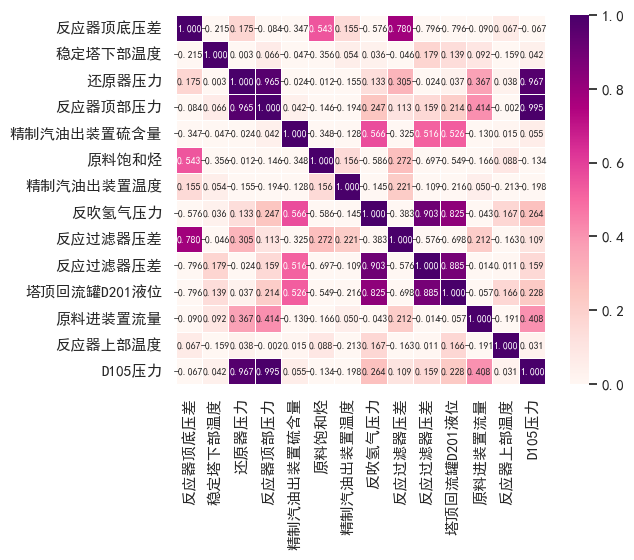

In [16]:
##制作热力图
#处理中文乱码
del_arr = df[del_feature]
snn.set(font_scale=1.0)
hm = snn.heatmap(del_arr.corr(),
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt=".3f",
                 vmin=0,             #刻度阈值
                 vmax=1,
                 linewidths=.5,
                 cmap="RdPu",        #刻度颜色
                 annot_kws={"size": 7},
                 xticklabels=True,
                 yticklabels=True)             #seaborn.heatmap相关属性
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [17]:
### 筛选出具有高度相关性的自变量
del_feature2 = ['D105压力','还原器压力','反吹氢气压力','反应器顶底压差','塔顶回流罐D201液位','反应过滤器压差','反应器顶部压力','精制汽油出装置温度']

end_feature = list(set(selected_feature1) -set(del_feature2))
print(end_feature)
print(len(end_feature))   ## 至此，建模所需要的30个特征变量选择完毕

['蒸汽进装置流量', '稳定塔下部温度', '蒸汽进装置压力', '燃料气进装置流量', '待生吸附S', '原料进装置流量', '精制汽油出装置流量', '反应器底部温度', '待生吸附-焦碳', '循环水出装置流量', 'D105流化氢气流量', '净化风进装置流量', '原料泵出口流量', '稳定塔液位', '反应器上部温度', '净化风进装置压力', '氮气进装置压力', 'D107提升氮气流量', '精制汽油出装置硫含量', '原料饱和烃', '轻烃出装置流量', '3#催化汽油进装置流量', '循环水进装置流量', '0.3MPa凝结水出装置流量', '原料硫含量', '原料密度', '原料辛烷值', '燃料气进装置压力', '氮气进装置流量', '污油出装置']
30


In [18]:
## 将筛选的变量与因变量组合在一个csv文件里，方便问题三建模使用
new_df = df[end_feature]
new_df['产品辛烷值'] = y
new_df['产品硫含量'] = y_s
new_df.to_csv('p3data.csv',index = False)

C:\Users\ndlcwx\AppData\Local\Temp\ipykernel_6256\3928341821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['产品辛烷值'] = y
C:\Users\ndlcwx\AppData\Local\Temp\ipykernel_6256\3928341821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['产品硫含量'] = y_s
